# 导入库

In [6]:
import sys, json, joblib, datetime, warnings, importlib
import numpy as np
import pandas as pd
import seaborn as sns
import baostock as bs
import matplotlib.pyplot as plt
from pathlib import Path
warnings.filterwarnings('ignore')

# 1.3 导入我们自己的模块
try:
    import get_data
    import save_data
    import build_models
    importlib.reload(get_data)
    importlib.reload(save_data)
    importlib.reload(build_models)
    print("SUCCESS: 自定义模块加载成功。")
except ImportError as e:
    print(f"ERROR: 模块导入失败: {e}\n请确保 get_data.py, save_data.py, build_models.py 文件与此 Notebook 在同一目录下。")

# 1.4 设置图表样式
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("环境设置与库导入完成。")

SUCCESS: 自定义模块加载成功。
环境设置与库导入完成。


# 参数设定

In [7]:
CONFIG_FILE_PATH = 'config.json'
try:
    with open(CONFIG_FILE_PATH, 'r', encoding='utf-8') as f: config = json.load(f)
    print(f"SUCCESS: 基础配置文件 '{CONFIG_FILE_PATH}' 加载成功。")
except FileNotFoundError:
    print(f"ERROR: 未找到配置文件 '{CONFIG_FILE_PATH}'。"); config = {}

# 2.2 设定本次预测的参数
prediction_params = {
    # 设置用于计算特征的历史数据长度（天数）
    "history_days_for_features": 365,
    
    # 定义每张图表显示多少支股票
    "stocks_per_chart": 1
}
print("\nSUCCESS: 本次预测的参数已定义。")
print(f"将使用过去 {prediction_params['history_days_for_features']} 天的数据来计算最新特征。")
print("\n注意：模型预测的未来天数（Horizon）由训练好的模型决定，无法在此处修改。")

SUCCESS: 基础配置文件 'config.json' 加载成功。

SUCCESS: 本次预测的参数已定义。
将使用过去 365 天的数据来计算最新特征。

注意：模型预测的未来天数（Horizon）由训练好的模型决定，无法在此处修改。


# 核心功能函数

In [8]:
def initialize_prediction_apis():
    """为预测流程初始化所有必要的API。"""
    print("INFO: 正在登录 Baostock API...")
    lg = bs.login()
    if lg.error_code != '0':
        print(f"ERROR: Baostock 登录失败: {lg.error_msg}")
        return False
    print("SUCCESS: Baostock API 登录成功。")
    return True

def load_latest_model(model_dir: Path, ticker: str):
    """为指定股票从模型目录加载最新版本的模型。"""
    stock_model_dir = model_dir / ticker
    if not stock_model_dir.exists():
        print(f"WARNNING: 未找到股票 {ticker} 的模型目录。")
        return None, None

    # 找到所有版本的模型目录，并按名称排序以获取最新的
    model_versions = sorted(list(stock_model_dir.glob("model_v_*")), reverse=True)
    if not model_versions:
        print(f"WARNNING: 股票 {ticker} 的模型目录为空。")
        return None, None

    latest_model_path = model_versions[0] / "inference_pipeline.joblib"
    metadata_path = model_versions[0] / "metadata.json"
    
    if not latest_model_path.exists():
        print(f"ERROR: 在最新版本目录 {model_versions[0]} 中未找到模型文件。")
        return None, None
        
    print(f"INFO: 正在为 {ticker} 加载模型: {latest_model_path.parent.name}")
    model = joblib.load(latest_model_path)
    
    with open(metadata_path, 'r', encoding='utf-8') as f:
        metadata = json.load(f)
        
    return model, metadata

def get_latest_features_for_prediction(ticker: str, benchmark_ticker: str, industry_etf_ticker: str, config: dict, history_days: int):
    """
    获取截至昨日的最新数据，并执行与训练时完全相同的特征工程流程。
    
    Args:
        history_days (int): 用于计算特征的历史数据天数。
    """
    print(f"INFO: 正在为 {ticker} 获取最近 {history_days} 天的数据...")
    end_date = datetime.date.today().strftime('%Y-%m-%d')
    # 使用传入的 history_days 参数
    start_date = (datetime.date.today() - datetime.timedelta(days=history_days)).strftime('%Y-%m-%d')
    
    shared_data = {}
    run_config = {**get_data.DEFAULT_CONFIG, **config.get('global_settings', {})}

    df = get_data._get_ohlcv_data_bs(get_data._get_api_ticker(ticker), start_date, end_date, run_config)
    if df is None or df.empty:
        print(f"ERROR: 无法获取 {ticker} 的最新行情数据。")
        return None, None

    macro_df = get_data._get_macroeconomic_data_cn(start_date, end_date, run_config)
    if macro_df is not None and not macro_df.empty:
        df = pd.merge_asof(df.sort_index(), macro_df.sort_index(), left_index=True, right_index=True, direction='backward')

    df = get_data._add_technical_and_calendar_features(df)
    
    bench_df_raw = get_data._get_ohlcv_data_bs(get_data._get_api_ticker(benchmark_ticker), start_date, end_date, run_config)
    ind_df_raw = get_data._get_ohlcv_data_bs(get_data._get_api_ticker(industry_etf_ticker), start_date, end_date, run_config)
    
    if bench_df_raw is not None and ind_df_raw is not None:
        bench_df = bench_df_raw['close_adj'].rename('benchmark_close')
        ind_df = ind_df_raw['close_adj'].rename('industry_close')
        df = get_data._add_relative_performance_features(df, bench_df, ind_df, run_config)
        
    df = get_data._make_features_stationary(df)
    
    df.ffill(inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    last_valid_day = df.dropna().iloc[[-1]]
    
    return last_valid_day, df

print("SUCCESS: 核心功能函数已定义。")

SUCCESS: 核心功能函数已定义。


# 预测模块

In [9]:
# 初始化API登录状态标志和预测结果列表
api_is_logged_in = False
predictions = []

# 步骤 3.1: 登录API
if config:
    api_is_logged_in = initialize_prediction_apis()

# 步骤 3.2: 循环执行预测 (仅在API登录成功后执行)
if config and api_is_logged_in:
    global_settings = config.get('global_settings', {})
    MODEL_DIR = Path(global_settings.get('model_dir', 'models'))
    
    for stock_config in config.get('stocks_to_process', []):
        
        # --- 核心修正区域 ---
        # 必须先获取 ticker，然后才能在获取 keyword 时使用它作为默认值
        ticker = stock_config.get("ticker")
        if not ticker:
            print(f"WARNNING: 跳过一个缺少 'ticker' 的配置项: {stock_config}")
            continue
        keyword = stock_config.get("keyword", ticker) # 现在 ticker 已定义，可以安全使用
        # --- 修正结束 ---

        print("\n" + "="*80)
        print(f"正在为 {keyword} ({ticker}) 进行预测...")
        
        model, metadata = load_latest_model(MODEL_DIR, ticker)
        if model is None: continue
            
        latest_features, _ = get_latest_features_for_prediction(
            ticker, 
            global_settings.get("benchmark_ticker"), 
            stock_config.get("industry_etf"), 
            config,
            history_days=prediction_params['history_days_for_features']
        )
        if latest_features is None: continue
            
        try:
            prediction_result = model.predict(latest_features)
            last_known_price = latest_features['close_adj'].iloc[0]
            result_dict = {
                "模型名称": keyword, "预测基准日期": latest_features.index[0].strftime('%Y-%m-%d'),
                "基准日收盘价": f"{last_known_price:.2f}",
            }
            for col in prediction_result.columns:
                quantile = float(col.split('_')[-1])
                return_val = prediction_result[col].iloc[0]
                price_val = last_known_price * (1 + return_val)
                result_dict[f"预测收益率 (q={quantile})"] = return_val
                result_dict[f"预测价格 (q={quantile})"] = price_val
            predictions.append(result_dict)
            print("SUCCESS: 预测完成。")
        except Exception as e:
            print(f"ERROR: 为 {keyword} 执行预测时失败: {e}")
    
    print("\nSUCCESS: 所有股票的预测流程已执行完毕。请继续运行下一个单元格进行分析。")
else:
    print("WARNNING: API初始化失败或配置加载失败，已跳过预测。")

INFO: 正在登录 Baostock API...
login success!
SUCCESS: Baostock API 登录成功。

正在为 长城军工 (601606.SH) 进行预测...
INFO: 正在为 601606.SH 加载模型: model_v_20251010_210818_2ec8d3
INFO: 正在为 601606.SH 获取最近 365 天的数据...
  - [1/7] 正在从 Baostock 下载 sh.601606 的日线行情...
  - INFO: 已将 sh.601606 的原始数据缓存至 data_cache\raw_ohlcv\raw_sh.601606_2024-10-10_2025-10-10.pkl
  - [3/7] 正在添加技术和日历特征...
  - [1/7] 正在从 Baostock 下载 sh.000300 的日线行情...
  - INFO: 已将 sh.000300 的原始数据缓存至 data_cache\raw_ohlcv\raw_sh.000300_2024-10-10_2025-10-10.pkl
  - [1/7] 正在从 Baostock 下载 sh.512660 的日线行情...
  - WARNING [BS]: 未能获取到 sh.512660 在指定日期范围的数据。
  - [5/7] 正在对特征进行平稳化...
SUCCESS: 预测完成。

正在为 长白山 (603099.SH) 进行预测...
INFO: 正在为 603099.SH 加载模型: model_v_20251010_210854_a9c5e4
INFO: 正在为 603099.SH 获取最近 365 天的数据...
  - [1/7] 正在从 Baostock 下载 sh.603099 的日线行情...
  - INFO: 已将 sh.603099 的原始数据缓存至 data_cache\raw_ohlcv\raw_sh.603099_2024-10-10_2025-10-10.pkl
  - [3/7] 正在添加技术和日历特征...
  - [1/7] 正在从本地缓存加载 sh.000300 的原始日线数据...
  - [1/7] 正在从 Baostock 下载 sh.512500 的日线行情...
  -

# 显示结果表格

,模型名称,预测基准日期,基准日收盘价,预测收益率 (q=0.5),预测价格 (q=0.5),预测收益率 (q=0.05),预测价格 (q=0.05),预测收益率 (q=0.95),预测价格 (q=0.95)
0,长城军工,2025-10-10,47.20,-15.98%,39.66,-17.86%,38.77,-10.64%,42.18
1,长白山,2025-10-10,44.48,52.95%,68.03,7.93%,48.01,52.95%,68.03
2,视觉中国,2025-10-10,23.21,1.76%,23.62,1.33%,23.52,1.76%,23.62
3,贵州茅台,2025-10-10,1430.00,1.30%,1448.56,-0.16%,1427.75,2.54%,1466.31
4,平安银行,2025-10-10,11.43,-0.35%,11.39,-0.35%,11.39,-0.35%,11.39
5,寒武纪-U,2025-10-10,1247.08,75.48%,2188.34,53.52%,1914.46,75.48%,2188.34
6,华星光电(TCL科技),2025-10-10,4.36,8.07%,4.71,6.66%,4.65,8.07%,4.71



预测分析 (批次 1)
- 长城军工       | 基准价: 47.20   | 预测中位价: 39.66   | 预测中位涨跌幅: -15.98%
INFO: 正在为 601606.SH 加载模型: model_v_20251010_210818_2ec8d3
INFO: 正在为 601606.SH 获取最近 365 天的数据...
  - [1/7] 正在从本地缓存加载 sh.601606 的原始日线数据...
  - [3/7] 正在添加技术和日历特征...
  - [1/7] 正在从本地缓存加载 sh.000300 的原始日线数据...
  - [1/7] 正在从 Baostock 下载 sh.512660 的日线行情...
  - WARNING [BS]: 未能获取到 sh.512660 在指定日期范围的数据。
  - [5/7] 正在对特征进行平稳化...


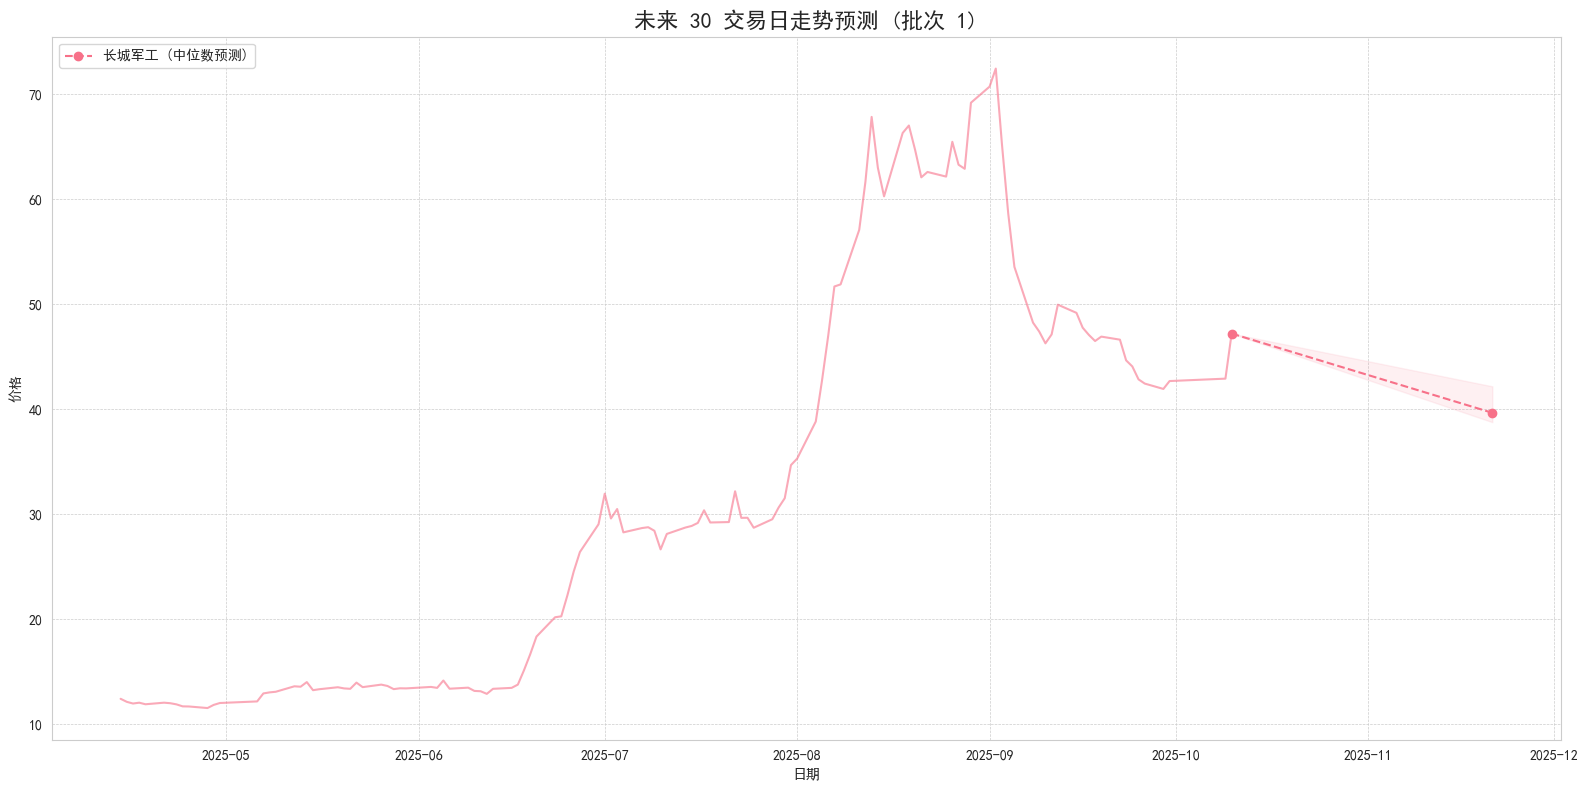


预测分析 (批次 2)
- 长白山        | 基准价: 44.48   | 预测中位价: 68.03   | 预测中位涨跌幅: +52.95%
INFO: 正在为 603099.SH 加载模型: model_v_20251010_210854_a9c5e4
INFO: 正在为 603099.SH 获取最近 365 天的数据...
  - [1/7] 正在从本地缓存加载 sh.603099 的原始日线数据...
  - [3/7] 正在添加技术和日历特征...
  - [1/7] 正在从本地缓存加载 sh.000300 的原始日线数据...
  - [1/7] 正在从 Baostock 下载 sh.512500 的日线行情...
  - WARNING [BS]: 未能获取到 sh.512500 在指定日期范围的数据。
  - [5/7] 正在对特征进行平稳化...


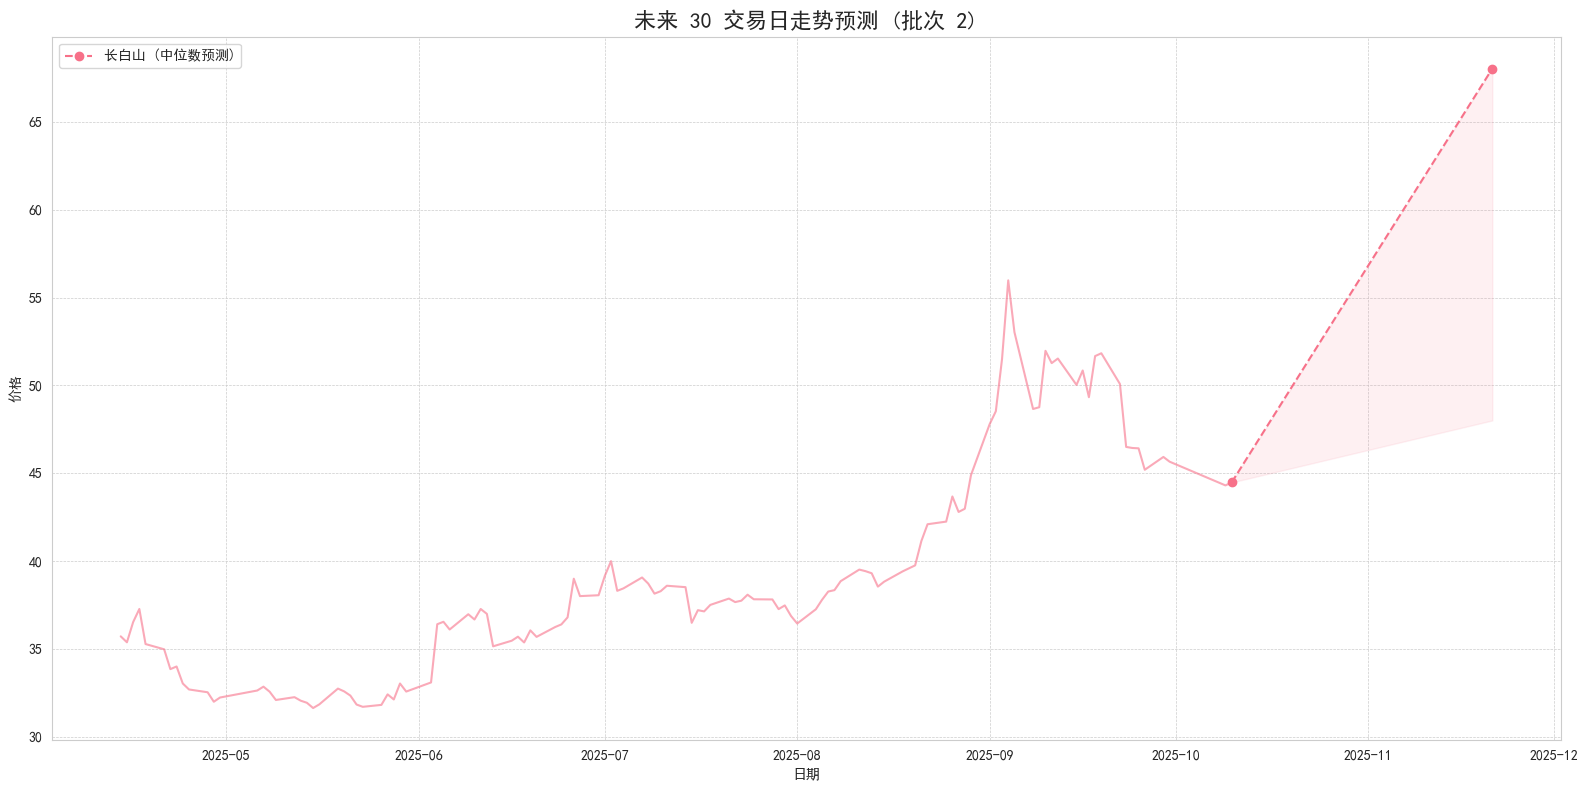


预测分析 (批次 3)
- 视觉中国       | 基准价: 23.21   | 预测中位价: 23.62   | 预测中位涨跌幅: +1.76%
INFO: 正在为 000681.SZ 加载模型: model_v_20251010_210933_80411f
INFO: 正在为 000681.SZ 获取最近 365 天的数据...
  - [1/7] 正在从本地缓存加载 sz.000681 的原始日线数据...
  - [3/7] 正在添加技术和日历特征...
  - [1/7] 正在从本地缓存加载 sh.000300 的原始日线数据...
  - [1/7] 正在从 Baostock 下载 sz.159965 的日线行情...
  - WARNING [BS]: 未能获取到 sz.159965 在指定日期范围的数据。
  - [5/7] 正在对特征进行平稳化...


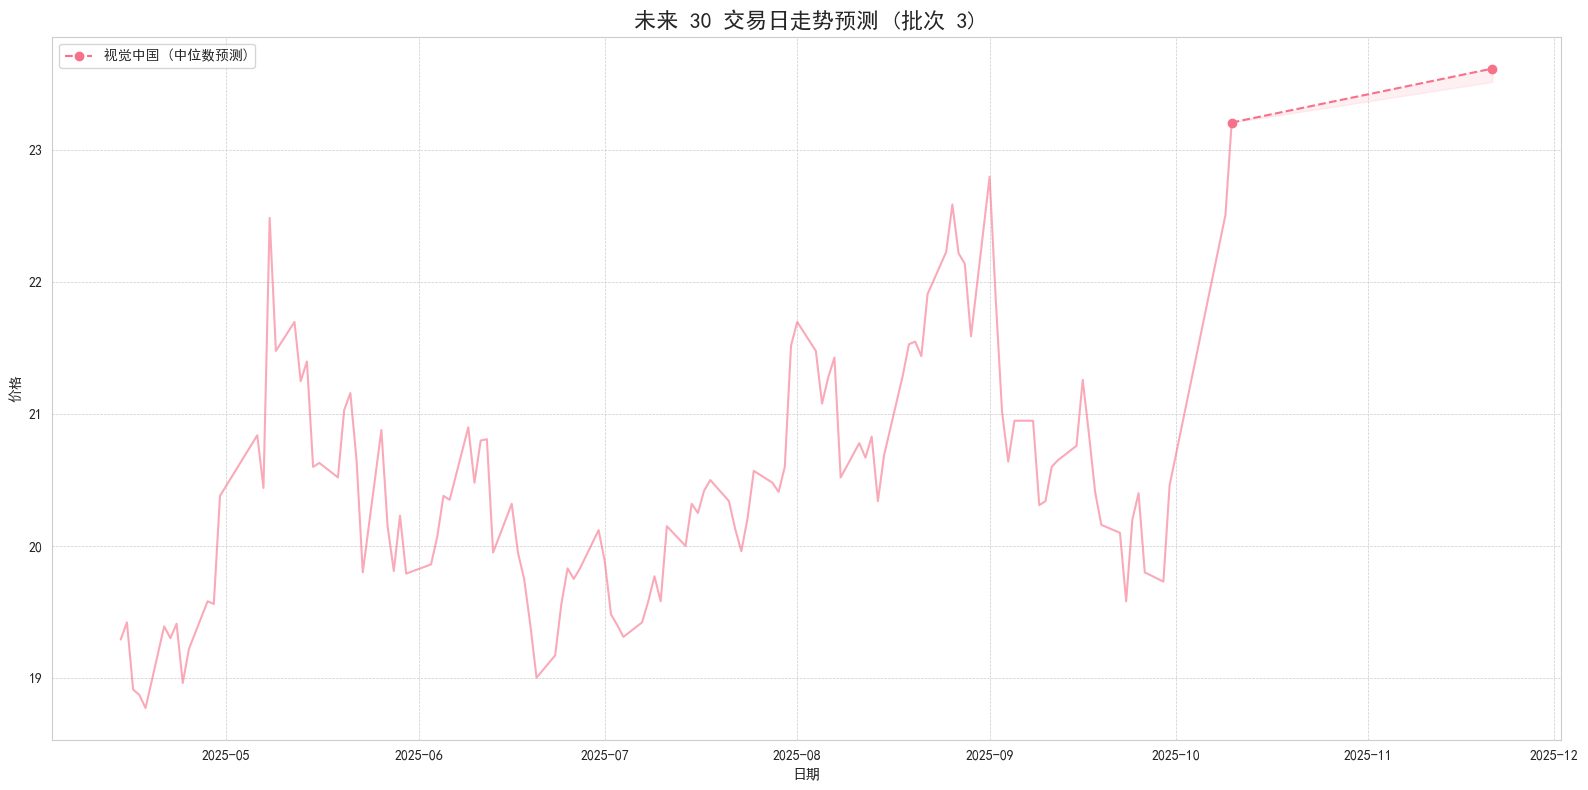


预测分析 (批次 4)
- 贵州茅台       | 基准价: 1430.00 | 预测中位价: 1448.56 | 预测中位涨跌幅: +1.30%
INFO: 正在为 600519.SH 加载模型: model_v_20251010_211014_6720aa
INFO: 正在为 600519.SH 获取最近 365 天的数据...
  - [1/7] 正在从本地缓存加载 sh.600519 的原始日线数据...
  - [3/7] 正在添加技术和日历特征...
  - [1/7] 正在从本地缓存加载 sh.000300 的原始日线数据...
  - [1/7] 正在从 Baostock 下载 sz.159928 的日线行情...
  - WARNING [BS]: 未能获取到 sz.159928 在指定日期范围的数据。
  - [5/7] 正在对特征进行平稳化...


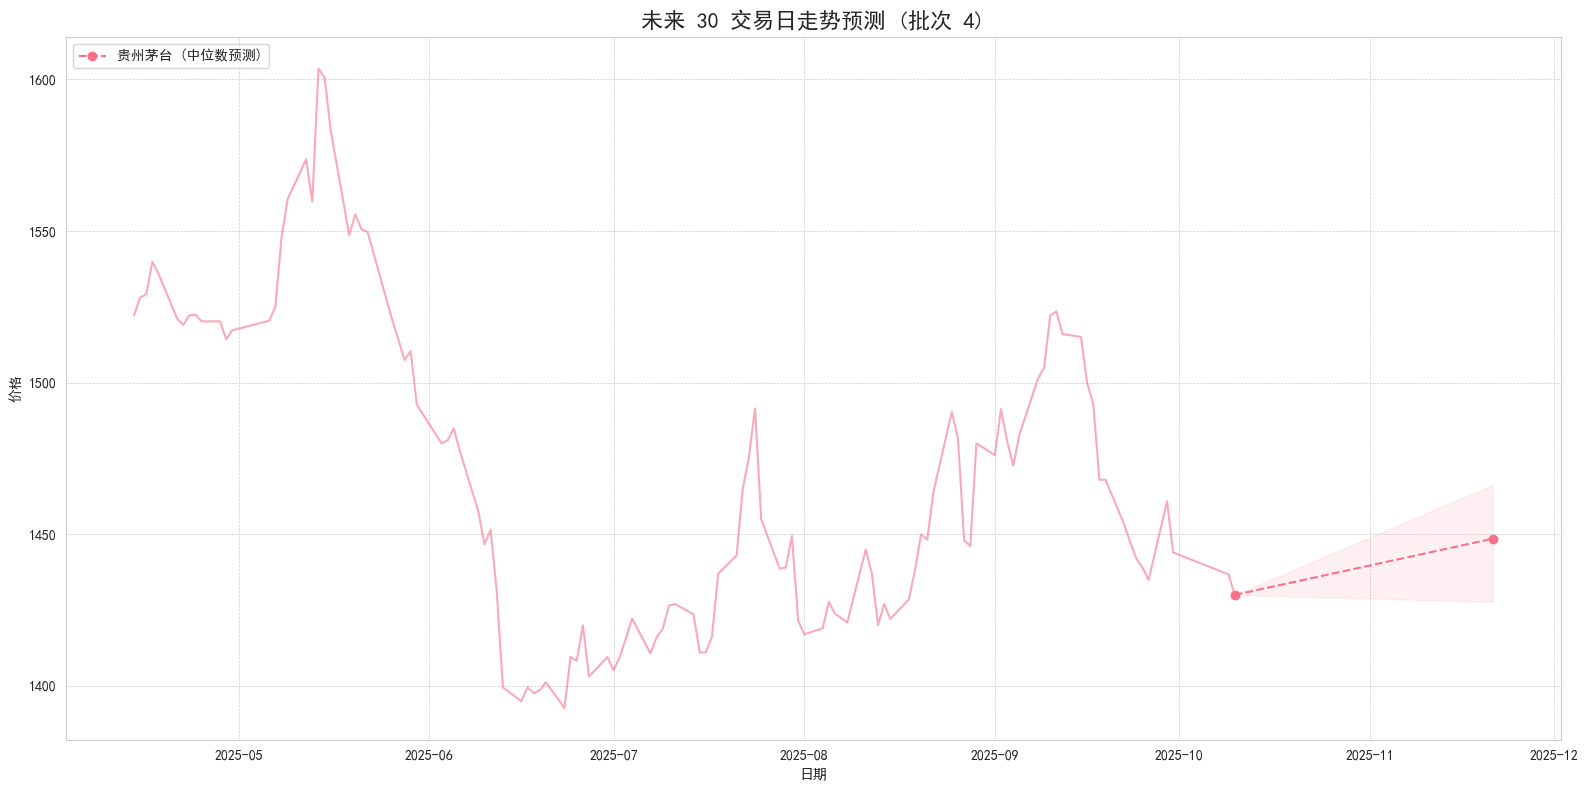


预测分析 (批次 5)
- 平安银行       | 基准价: 11.43   | 预测中位价: 11.39   | 预测中位涨跌幅: -0.35%
INFO: 正在为 000001.SZ 加载模型: model_v_20251010_211101_c70247
INFO: 正在为 000001.SZ 获取最近 365 天的数据...
  - [1/7] 正在从本地缓存加载 sz.000001 的原始日线数据...
  - [3/7] 正在添加技术和日历特征...
  - [1/7] 正在从本地缓存加载 sh.000300 的原始日线数据...
  - [1/7] 正在从 Baostock 下载 sh.512800 的日线行情...
  - WARNING [BS]: 未能获取到 sh.512800 在指定日期范围的数据。
  - [5/7] 正在对特征进行平稳化...


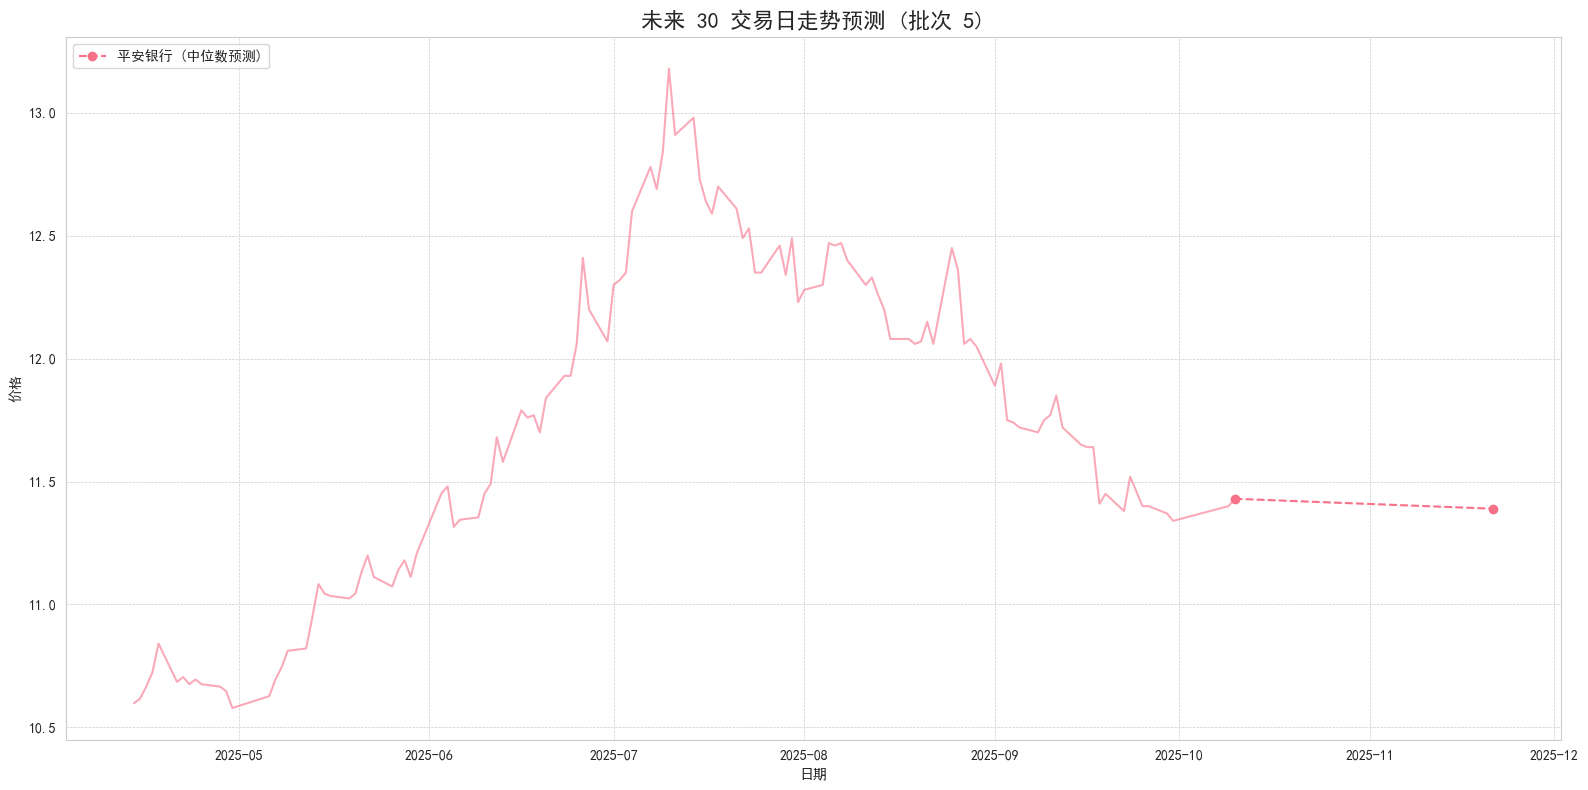


预测分析 (批次 6)
- 寒武纪-U      | 基准价: 1247.08 | 预测中位价: 2188.34 | 预测中位涨跌幅: +75.48%
INFO: 正在为 688256.SH 加载模型: model_v_20251010_211135_b2e83e
INFO: 正在为 688256.SH 获取最近 365 天的数据...
  - [1/7] 正在从本地缓存加载 sh.688256 的原始日线数据...
  - [3/7] 正在添加技术和日历特征...
  - [1/7] 正在从本地缓存加载 sh.000300 的原始日线数据...
  - [1/7] 正在从 Baostock 下载 sz.159995 的日线行情...
  - WARNING [BS]: 未能获取到 sz.159995 在指定日期范围的数据。
  - [5/7] 正在对特征进行平稳化...


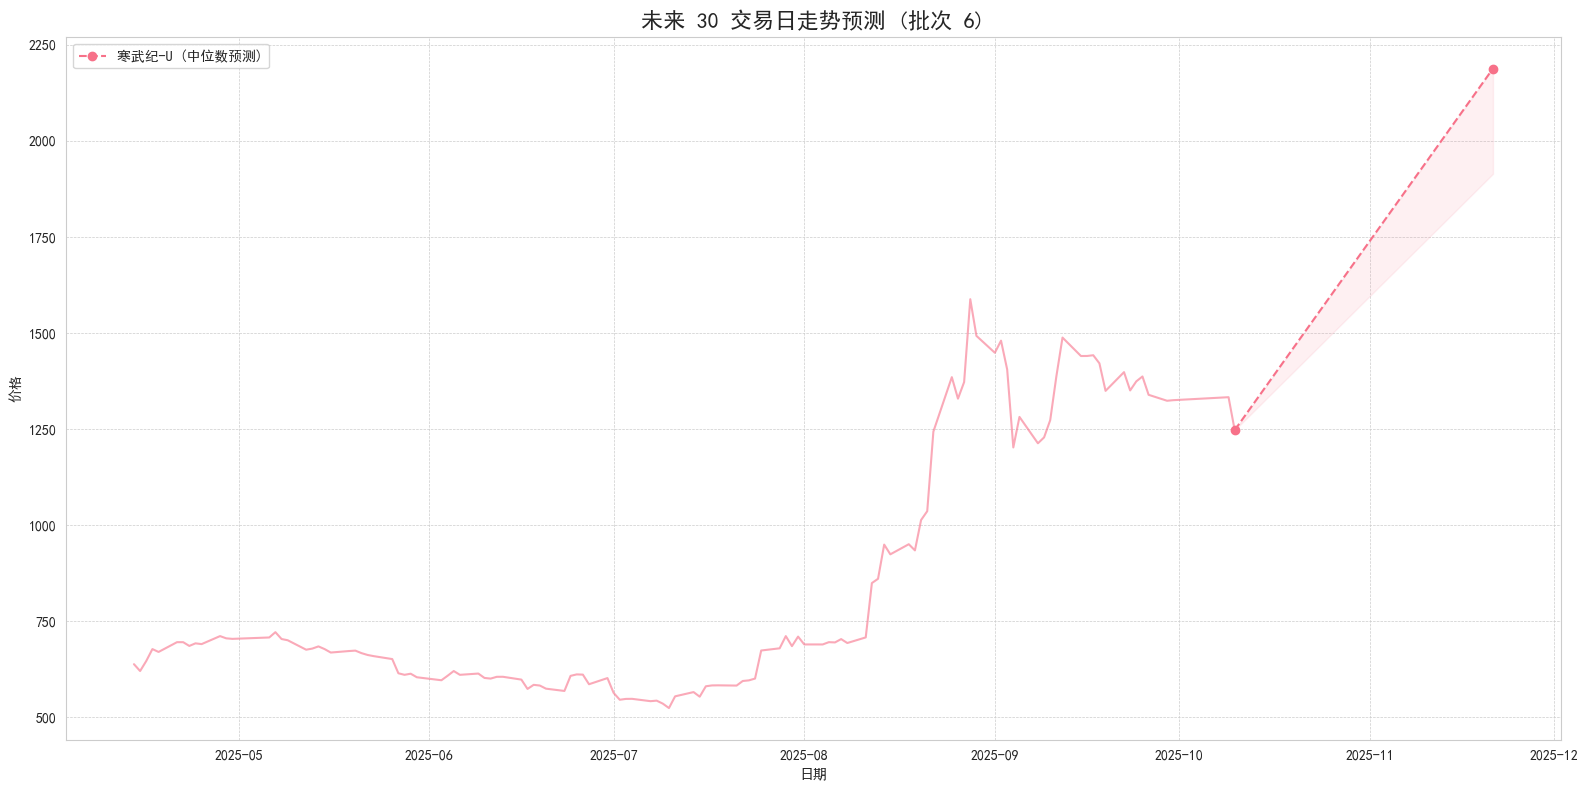


预测分析 (批次 7)
- 华星光电(TCL科技) | 基准价: 4.36    | 预测中位价: 4.71    | 预测中位涨跌幅: +8.07%
INFO: 正在为 000100.SZ 加载模型: model_v_20251010_211229_6fd1aa
INFO: 正在为 000100.SZ 获取最近 365 天的数据...
  - [1/7] 正在从本地缓存加载 sz.000100 的原始日线数据...
  - [3/7] 正在添加技术和日历特征...
  - [1/7] 正在从本地缓存加载 sh.000300 的原始日线数据...
  - [1/7] 正在从 Baostock 下载 sz.159928 的日线行情...
  - WARNING [BS]: 未能获取到 sz.159928 在指定日期范围的数据。
  - [5/7] 正在对特征进行平稳化...


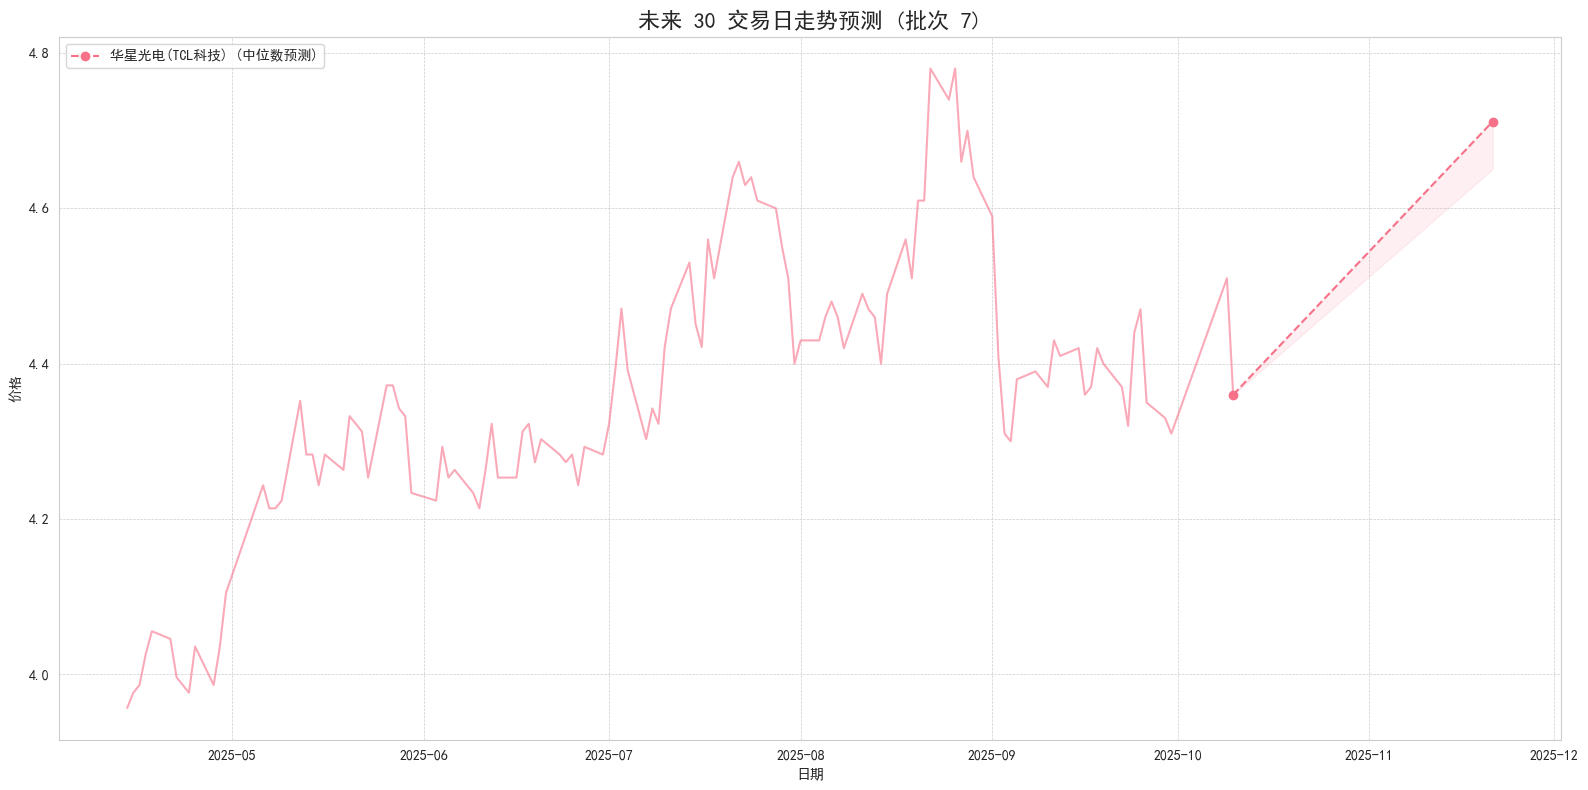

logout success!
INFO: Baostock API 已登出。


In [10]:
# 步骤 4.1: 显示结果表格
if predictions:
    results_df = pd.DataFrame(predictions)
    display_cols = ['模型名称', '预测基准日期', '基准日收盘价', '预测收益率 (q=0.5)', '预测价格 (q=0.5)', '预测收益率 (q=0.05)', '预测价格 (q=0.05)', '预测收益率 (q=0.95)', '预测价格 (q=0.95)']
    formatters = {'预测收益率 (q=0.5)': '{:.2%}', '预测价格 (q=0.5)': '{:.2f}', '预测收益率 (q=0.05)': '{:.2%}', '预测价格 (q=0.05)': '{:.2f}', '预测收益率 (q=0.95)': '{:.2%}', '预测价格 (q=0.95)': '{:.2f}'}
    display(results_df[display_cols].style.format(formatters).set_caption("未来走势预测汇总"))
else:
    print("WARNNING: 没有可供分析的预测结果。请先成功运行上一个单元格。")

# 步骤 4.2: 详细解读与批量可视化
if predictions and api_is_logged_in:
    # 定义每张图表显示多少支股票
    STOCKS_PER_CHART = prediction_params['stocks_per_chart']
    
    # 以 STOCKS_PER_CHART 为步长，遍历所有预测结果，实现分批处理
    for i in range(0, len(predictions), STOCKS_PER_CHART):
        batch = predictions[i:i + STOCKS_PER_CHART]
        
        # --- 文本分析 ---
        print("\n" + "="*80 + f"\n预测分析 (批次 {i//STOCKS_PER_CHART + 1})\n" + "="*80)
        analysis_texts = []
        for stock_to_analyze in batch:
            keyword = stock_to_analyze['模型名称']
            last_price = float(stock_to_analyze['基准日收盘价'])
            pred_median_price = stock_to_analyze['预测价格 (q=0.5)']
            predicted_return = (pred_median_price / last_price) - 1
            analysis_texts.append(f"- {keyword:<10} | 基准价: {last_price:<7.2f} | 预测中位价: {pred_median_price:<7.2f} | 预测中位涨跌幅: {predicted_return:+.2%}")
        print("\n".join(analysis_texts) + "\n" + "="*80)
        
        # --- 可视化分析 ---
        fig, ax = plt.subplots(figsize=(16, 8))
        colors = sns.color_palette("husl", n_colors=len(batch))
        
        # 初始化一个 horizon 变量，用于图表标题
        horizon_for_title = 'N/A'
        
        for j, stock_to_analyze in enumerate(batch):
            keyword, color = stock_to_analyze['模型名称'], colors[j]
            
            # 使用 keyword 找到对应的 ticker 配置
            ticker_config = next((s for s in config['stocks_to_process'] if s['keyword'] == keyword), None)
            if not ticker_config:
                print(f"WARNNING: 在 config.json 中找不到 keyword 为 '{keyword}' 的配置，跳过绘图。")
                continue

            # 加载模型和元数据
            model, metadata = load_latest_model(Path(config['global_settings']['model_dir']), ticker_config['ticker'])
            
            # 重新获取绘图所需的历史数据
            _, history_df = get_latest_features_for_prediction(
                ticker_config['ticker'], config['global_settings']['benchmark_ticker'], ticker_config['industry_etf'], config,
                history_days=prediction_params['history_days_for_features']
            )
            
            if history_df is None or model is None or metadata is None:
                print(f"WARNNING: 无法为 {keyword} 加载绘图所需数据，跳过。")
                continue

            # --- 健壮性修复：安全地获取 horizon ---
            # 这样即使 metadata 中缺少 config_snapshot 键，代码也不会崩溃
            horizon = metadata.get('config_snapshot', {}).get('labeling_horizon', 30)
            if j == 0: horizon_for_title = horizon # 仅使用第一个模型的 horizon 作为标题
            # --- 修复结束 ---
            
            last_day, last_price = pd.to_datetime(stock_to_analyze['预测基准日期']), float(stock_to_analyze['基准日收盘价'])
            pred_median_price, pred_lower_price, pred_upper_price = stock_to_analyze['预测价格 (q=0.5)'], stock_to_analyze['预测价格 (q=0.05)'], stock_to_analyze['预测价格 (q=0.95)']
            
            plot_history = history_df['close_adj'].tail(120)
            ax.plot(plot_history.index, plot_history.values, color=color, alpha=0.6)
            future_dates = pd.date_range(start=last_day, periods=int(horizon) + 1, freq='B')
            ax.plot([plot_history.index[-1], future_dates[-1]], [last_price, pred_median_price], color=color, linestyle='--', marker='o', label=f'{keyword} (中位数预测)')
            ax.fill_between([plot_history.index[-1], future_dates[-1]], [last_price, pred_lower_price], [last_price, pred_upper_price], color=color, alpha=0.1)

        ax.set_title(f'未来 {horizon_for_title} 交易日走势预测 (批次 {i//STOCKS_PER_CHART + 1})', fontsize=16)
        ax.set_ylabel('价格'); ax.set_xlabel('日期'); ax.legend(loc='upper left'); ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout(); plt.show()
else:
    print("没有可供分析的详细预测，或API未登录。")

if api_is_logged_in:
    bs.logout()
    # 将标志位重置，防止重复登出或在未登录状态下误操作
    api_is_logged_in = False 
    print("INFO: Baostock API 已登出。")
else:
    print("INFO: API 未处于登录状态，无需登出。")